# Data Extraction
### code from `data_loader_demo.ipynb`

In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Exploration
import matplotlib.pyplot as plt

# Feature Engineering
import numpy as np
import pandas as pd

import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
import params as p

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Financial Phrasebank

In [2]:
# The financial_phrasebank dataset is available in four variations. It has no predefined train/validation/test splits.
# Each data point was annotated by 5-8 people, then their annotations were combined. 
# Each variation of the dataset contains examples with different levels of agreement. 
# Let's use the one containing all data points where at least 50% of the annotators agreed on the label.
dataset = load_dataset(
    "financial_phrasebank", 
    'sentences_50agree' # Select variation of the dataset
)

print(f'The dataset is a dictionary with two splits: \n\n{dataset}')

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 72.63it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})


In [3]:
# Split test data from training data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    dataset["train"]['sentence'], 
    dataset["train"]['label'], 
    test_size=0.2, 
    stratify=dataset["train"]['label']  # make sure the same proportion of labels is in the test set and training set
)

In [4]:
# label 0 = negative, 1 = neutral, 2 = positive
print(f'How many instances in the train dataset? \n\n{len(train_sentences)}')
print('')
print(f'What does one instance look like? \n\n{train_sentences[234]}')

How many instances in the train dataset? 

3876

What does one instance look like? 

The platform would continue to be the development framework for Symbian and MeeGo .


It may also be necessary to create a _validation_ set (also called 'development' set or 'devset'). The validation set can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specifso it gets good performance on the test set examples. 

In [5]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.25, stratify=train_labels)


In [6]:
print(f'How many instances in the validation dataset? \n\n{len(val_sentences)}\n')
print(f'How many instances in the test dataset? \n\n{len(test_sentences)}')

How many instances in the validation dataset? 

969

How many instances in the test dataset? 

970


# Data Exploration

In [7]:
train = pd.DataFrame({'sentences' : train_sentences, 'labels' : train_labels})

## Very Brief Response Analysis

Should only need to do this for train due to random split. So would expect to see the same structure for test and val

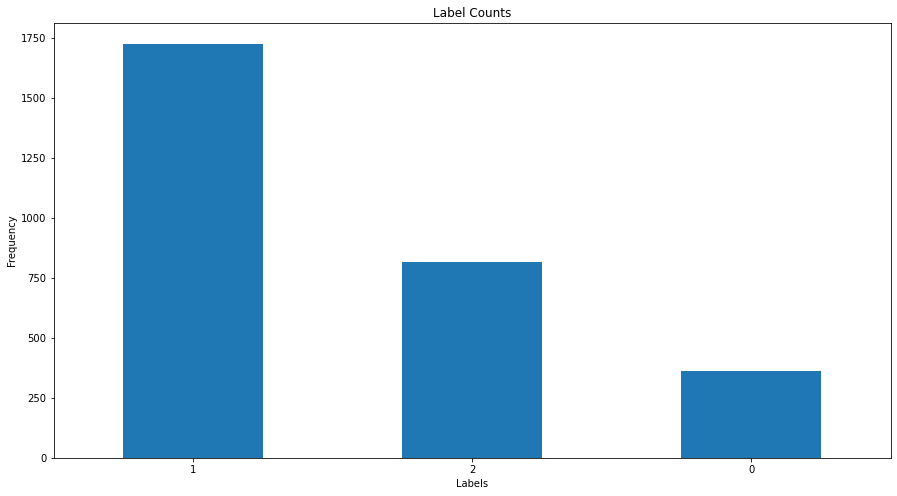

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))

ax = train.labels.value_counts().plot(kind='bar', title = 'Label Counts')

ax.set_xlabel("Labels")
ax.set_ylabel("Frequency")
plt.xticks(rotation = 0)

plt.show()

Slight Imbalance of labels, but nothing that will be an issue

# Featuring Engineering

### Sentence Processing

In [9]:
# remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

# load up a simple porter stemmer - nothing fancy
ps = nltk.porter.PorterStemmer()

def simple_text_preprocessor(document): 
    # lower case
    document = str(document).lower()
    
    # remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    document = re.sub(r'nbsp', r'', document)
    document = re.sub(' +', ' ', document)
    
    # simple porter stemming
    document = ' '.join([ps.stem(word) for word in document.split()])
    
    # stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])
    
    return document

stp = np.vectorize(simple_text_preprocessor)

In [10]:
clean_train_sentences = stp(train_sentences)
clean_test_sentences = stp(test_sentences)
clean_val_sentences = stp(val_sentences)

In [11]:
tfidf = TfidfVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (1, 2))

In [12]:
X_train = tfidf.fit_transform(clean_train_sentences).toarray()
X_train = pd.DataFrame(X_train, columns = tfidf.get_feature_names_out())

X_test = tfidf.transform(clean_test_sentences).toarray()
X_test = pd.DataFrame(X_test, columns = tfidf.get_feature_names_out())

X_val = tfidf.transform(clean_val_sentences).toarray()
X_val = pd.DataFrame(X_val, columns = tfidf.get_feature_names_out())

In [13]:
X_train.head()

,aalborg,aalborg northern,aaltonen,aaltonen finland,aava,aava mobil,aazhang,aazhang behnaam,ab,ab finnish,...,zinc mine,zinc stream,zip,zip expert,zone,zone neudorf,zoo,zoo poland,zte,zte corp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [14]:
y_train = train_labels
y_test = test_labels
y_val = val_labels

In [15]:
def evaluate_model(model, X, y):

    y_pred = model.predict(X)

    print('MACRO')
    acc = accuracy_score(y, y_pred)
    print(f'Accuracy:\t {acc}')

    prec = precision_score(y, y_pred, average='macro')
    print(f'Precision:\t {prec}')

    rec = recall_score(y, y_pred, average='macro')
    print(f'Recall:\t\t {rec}')

    f1 = f1_score(y, y_pred, average='macro')
    print(f'F1 score:\t {f1}')

    # We can get all of these with a per-class breakdown using classification_report:
    print(classification_report(y, y_pred))

In [16]:
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

In [17]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [18]:
evaluate_model(nb, **test_data)

MACRO
Accuracy:	 0.668041237113402
Precision:	 0.6543181826329809
Recall:		 0.4327683049273958
F1 score:	 0.4191596681743343
              precision    recall  f1-score   support

           0       0.62      0.04      0.08       121
           1       0.67      0.99      0.80       576
           2       0.67      0.27      0.38       273

    accuracy                           0.67       970
   macro avg       0.65      0.43      0.42       970
weighted avg       0.66      0.67      0.59       970



In [19]:
rf = RandomForestClassifier(random_state=p.RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=73)

In [20]:
evaluate_model(rf, **test_data)

MACRO
Accuracy:	 0.7371134020618557
Precision:	 0.7248473748473749
Recall:		 0.5727936310322673
F1 score:	 0.6060171065162577
              precision    recall  f1-score   support

           0       0.71      0.29      0.41       121
           1       0.74      0.96      0.84       576
           2       0.72      0.47      0.57       273

    accuracy                           0.74       970
   macro avg       0.72      0.57      0.61       970
weighted avg       0.73      0.74      0.71       970



### Post-tuned Performance

In [21]:
evaluate_model(nb, **val_data)

MACRO
Accuracy:	 0.6780185758513931
Precision:	 0.7808237319560324
Recall:		 0.4537124250526657
F1 score:	 0.4540828161977169
              precision    recall  f1-score   support

           0       1.00      0.08      0.15       121
           1       0.68      0.98      0.80       576
           2       0.67      0.29      0.41       272

    accuracy                           0.68       969
   macro avg       0.78      0.45      0.45       969
weighted avg       0.71      0.68      0.61       969



In [22]:
evaluate_model(rf, **val_data)

MACRO
Accuracy:	 0.7337461300309598
Precision:	 0.7488392429869638
Recall:		 0.5834678109076505
F1 score:	 0.6224852833942897
              precision    recall  f1-score   support

           0       0.80      0.34      0.48       121
           1       0.74      0.94      0.83       576
           2       0.71      0.47      0.57       272

    accuracy                           0.73       969
   macro avg       0.75      0.58      0.62       969
weighted avg       0.74      0.73      0.71       969

